In [160]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# 1. PCA Faces

In [161]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

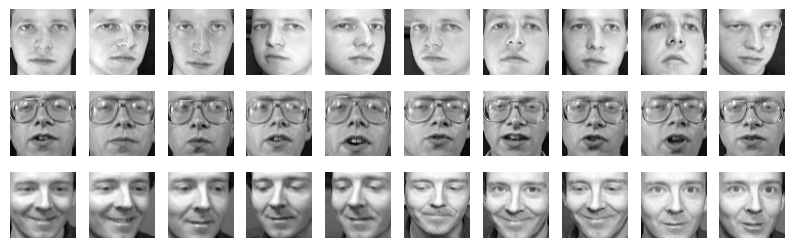

In [162]:
# This is how you plot the first thirty pictures of the dataset
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(faces.data[i].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [163]:
D = faces.data
D.shape

(400, 4096)

## 1.a

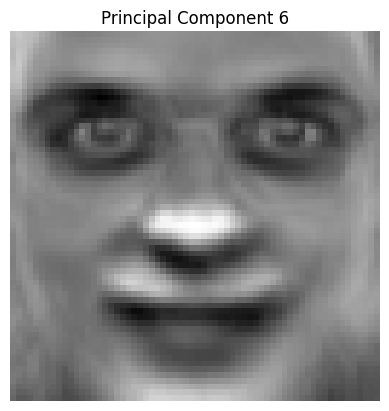

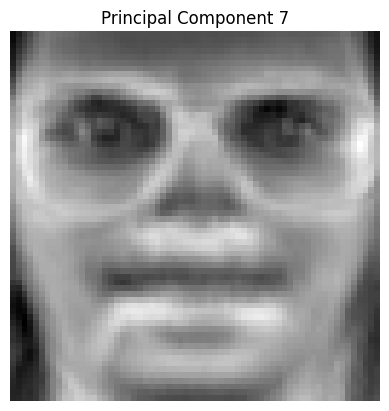

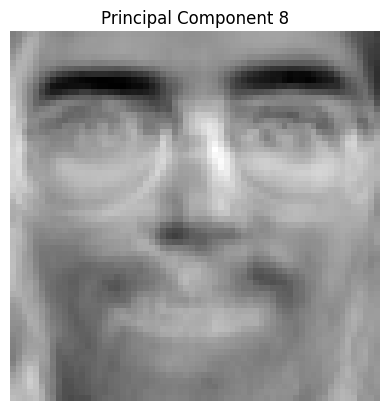

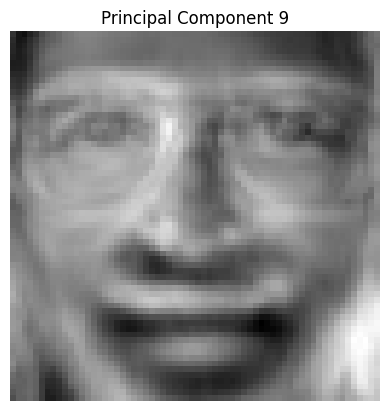

In [164]:
# get height and width of images
h, w = faces.images[0].shape

pca = PCA()
# generate learning params and fit data
D_transformed = pca.fit_transform(D)

# mind the difference between PC value and array index
for index in range(6,10):
    # reshape back from flattened 1D to 2D
    principal_component = pca.components_[index-1].reshape((h,w))

    plt.figure()
    plt.imshow(principal_component, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(f'Principal Component {index}')
    plt.show()

## 1.b

In [165]:
# dimension 3
pca = PCA(3)

# 5th datapoint, index 4
pca.fit_transform(D)[4]

array([-3.9620035, -3.2938752,  3.6528738], dtype=float32)

## 1.c

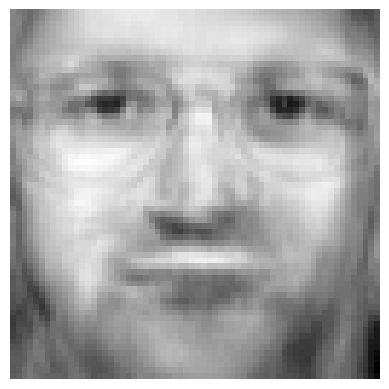

In [166]:


mean_vector = np.mean(D, axis=0)
centered_data = D - mean_vector

# Perform SVD
U, s, V = sp.linalg.svd(centered_data, full_matrices=False)
# rank 50
Vtr = V[:50, :]

# [0.5, ..., -0.5] vector
base_vector = [0.5 for i in range(0,25)] + [-0.5 for i in range(0,25)]

# construct image from vector and reshape/unflatten
reconstructed_image = (np.dot(base_vector, Vtr) + mean_vector).reshape(h,w)

# plot image
plt.figure()
plt.imshow(reconstructed_image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

# 2. k-means initialization

In [167]:
from sklearn import datasets
from sklearn import metrics

The functions generating the datasets are given here:

In [168]:
def generateMoons(epsilon, n):
    moons, labels = datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 1.5, epsilon + 0.5], random_state=54)
    return "blobs", blobs, labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [169]:
def sum_quadratic_dist(D, i):
    dist = 0
    for row in D:
        dist += np.linalg.norm(row - D[i,:])**2
    return dist

# quadratic distance from v to the closest column vector in X
def quadratic_closest(v, X):
    d_min = float('inf')
    for column in np.atleast_2d(X).T:
        d_min = min(d_min, np.linalg.norm(column - v)**2)
    return d_min

def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape
    D = np.atleast_2d(D)

    indexes = rng.integers(low=0, high=n, size=l) # 1.

    i_min = -1 # 2.
    d_min = float('inf')
    for i in indexes:
        d = sum_quadratic_dist(D, i)
        if d < d_min:
            i_min = i
            d_min = d

    X = np.atleast_2d(D[i_min,:]).T # 3.

    for _ in range(r-1): # 5.
        p = np.zeros(n) # gather probabilities for 5.1
        s = 0 # compute denominator for 5.1
        for j in range(n):
            s += quadratic_closest(D[j,:], X)
        for i in range(n):
            p[i] = quadratic_closest(D[i,:], X) / s
        indexes = rng.choice(np.arange(n), size=l, p=p) # 5.1

        i_min = -1 # 5.2
        d_min = float('inf')
        for i in indexes:
            d = 0
            for j in range(n):
                d += quadratic_closest(D[j,:], np.append(np.atleast_2d(X), np.atleast_2d(D[i,:]).T, axis=1))
            if d < d_min:
                i_min = i
                d_min = d

        X = np.append(np.atleast_2d(X), np.atleast_2d(D[i_min,:]).T, axis=1) # 5.3
        
    return X # 6

In [170]:
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function 
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''  
    np.random.seed(0)
    L = np.diag(np.array(W.sum(0))[0]) - W
    v0 = np.random.rand(min(L.shape))
    Lambda, V = sp.sparse.linalg.eigsh(L, k=r+1, which="SM", v0=v0)
    A = V[:,1:] #remove the first eigenvector, assuming that the graph is conected
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)

    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [171]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

## Running k-means on the blobs dataset
We generate the blobs dataset. Run kmeans based on the initialization technique. Finally, we plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

In [172]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)

In [173]:
X_init = init_centroids_greedy_pp(D,r)
X,Y = kmeans(D,r, X_init)
approx_error_blobs = RSS(D, X, Y) / (D.shape[0] * D.shape[1])
print(f"blobs, mean approximation error: {approx_error_blobs}")

labels_pred = np.zeros(n)
for i in range(n):
    labels_pred[i] = np.argmax(Y[i])
print(f"blobs nmi: {metrics.normalized_mutual_info_score(labels, labels_pred)}")

6 iterations
blobs, mean approximation error: 1.234565237648824
blobs nmi: 0.9527380045058215


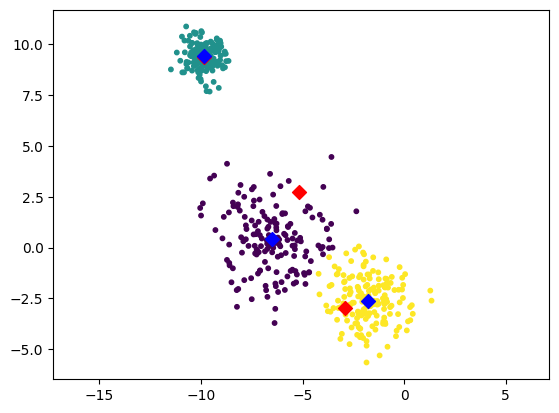

In [174]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D') # initial centroids are in red
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D') # computed centroids are in blue
plt.show()

## Running spectral clustering on the two moons dataset
We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [175]:
dataID, D, labels, r = generateMoons(0.05,n)

5 iterations
moons nmi knn=5: 0.03501569892480098


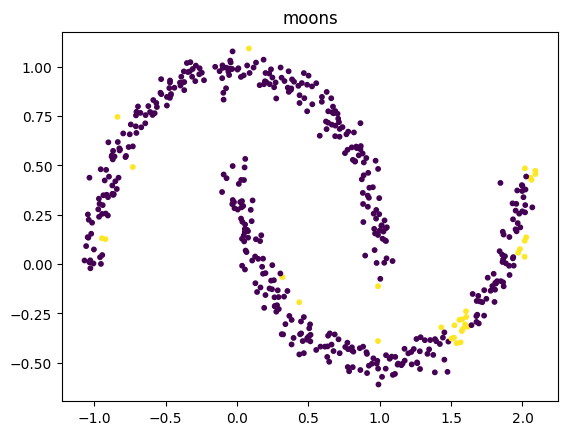

2 iterations
moons nmi knn=10: 0.00392410573208431


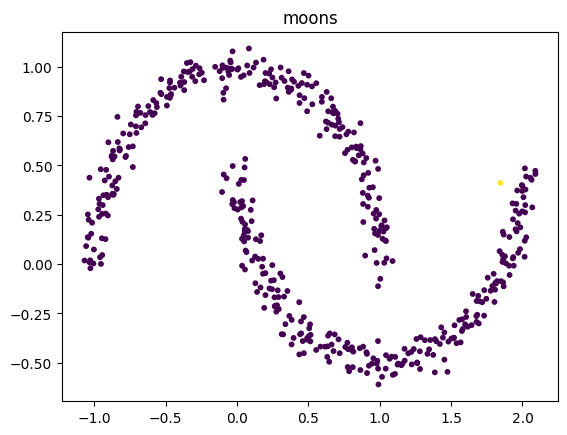

7 iterations
moons nmi knn=20: 0.07041903090474787


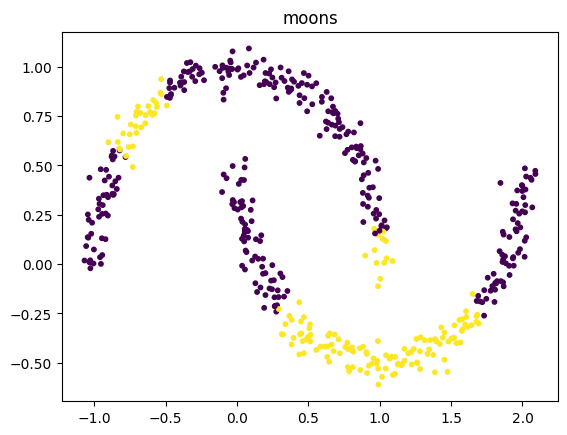

4 iterations
moons nmi knn=40: 0.34371101848544966


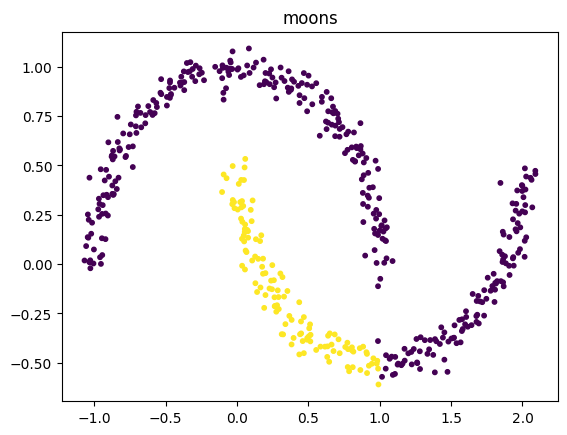

In [176]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
# Implement here the computation of W as knn graph
# W = radius_neighbors_graph(D,0.5,include_self=False)
knn_set = [5, 10, 20, 40]
labels_pred = np.zeros(n)
for knn in knn_set:
    W = kneighbors_graph(D,knn,include_self=False)
    Y = spectral_clustering(W,r,init_centroids_greedy_pp)
    for i in range(n):
        labels_pred[i] = np.argmax(Y[i])
    print(f"moons nmi knn={knn}: {metrics.normalized_mutual_info_score(labels, labels_pred)}")

    plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
    plt.title('%s'  % ( dataID) )
    plt.show()

# 3. Your own personal Netflix

To read the dataset you might need to alter the path to look for it:

In [177]:
import pandas as pd # pandas is a data manipulation library
# lets explore movies.csv
movies= pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [178]:
# lets explore ratings.CSV
ratings=pd.read_csv('ml-latest-small/ratings.csv',sep=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The given ratings are in the range of 0.5 and 5:

In [179]:
min(ratings["rating"]), max(ratings["rating"])

(0.5, 5.0)

We convert the sparse data representation of movie ratings into a data matrix. The missing values are filled with zeros.

In [180]:
df_movie_ratings = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  #fill unobserved entries with μ
df_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We consider here only the movies which have been rated by more than 100 users. That are 134 movies. We will not be able to infer a pattern for movies with very few observations anyways, but for this exercise we are mostly interested in the principle and do not need a big dataset.

In [181]:
np.sum(np.sum(df_movie_ratings!=0,0)>100)

134

In [182]:
keep_movie = np.sum(df_movie_ratings!=0,0)>100
df_D = df_movie_ratings.loc[:,keep_movie]
df_D.head()

movieId,1,2,6,10,32,34,39,47,50,110,...,7153,7361,7438,8961,33794,48516,58559,60069,68954,79132
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Furthermore, we will throw out all the users which have rated fewer than five movies. It would be hard anyways to make recommendations based on 4 movies.

In [183]:
np.sum(np.sum(df_D!=0,1)>=5)

556

The resulting dataset has the userID as rows and movieIDs as columns. Hence, userID 1 and 4 addresses the first two rows of this dataset.

In [184]:
keep_user = np.sum(df_D!=0,1)>=5
df_D = df_D.loc[keep_user,:]
df_D.head()

movieId,1,2,6,10,32,34,39,47,50,110,...,7153,7361,7438,8961,33794,48516,58559,60069,68954,79132
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0,4.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,4.0,3.0,4.0,4.0,0.0,4.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The movie number- title assignments are given as follows:

In [185]:
selected_movies = movies.loc[movies['movieId'].isin(df_D.columns)]
selected_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
5,6,Heat (1995),Action|Crime|Thriller
9,10,GoldenEye (1995),Action|Adventure|Thriller
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
...,...,...,...
6315,48516,"Departed, The (2006)",Crime|Drama|Thriller
6710,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
6772,60069,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi
7039,68954,Up (2009),Adventure|Animation|Children|Drama


The resulting data matrix is given as follows:

In [186]:
D = df_D.to_numpy()
D.shape

(556, 134)

## Optimization
Use the following initialization for your implementation of the optimization scheme.

In [187]:
def matrix_completion(D, r, t_max=100, λ = 0.1):
    n,d = D.shape
    # r = np.random.randint(1,np.min([n,d]))
    np.random.seed(0)
    X = np.random.normal(size =(d,r))
    Y = np.random.normal(size =(n,r))
    O = np.zeros_like(D)
    O[np.nonzero(D)] = 1
    
    # Implement now the optimization procedure
    for t in range(t_max):
        for k in range(d):
            Oxk = np.diag(O[:,k])
            inv = sp.linalg.inv(np.matmul(np.matmul(np.transpose(Y),Oxk),Y)+λ*np.identity(r))
            X[k] = np.matmul(np.matmul(np.transpose(D[:,k]),Y),inv)
        for i in range(n):
            Oyi= np.diag(O[i,:])
            inv = sp.linalg.inv(np.matmul(np.matmul(np.transpose(X),Oyi),X)+λ*np.identity(r))
            Y[i] = np.matmul(np.matmul(D[i,:],X),inv)
    return X,Y

## 3.a

In [188]:
X1,Y1 = matrix_completion(D,r=20,t_max=100,λ=0.1)

In [68]:
def getAproxError(X,Y):
    O = np.zeros_like(D) 
    O[np.nonzero(D)] = 1
    D_aprox = np.multiply(O,np.matmul(Y,np.transpose(X)))
    err = sp.linalg.norm(D-D_aprox)**2/O.sum()
    print(err)
    return err

In [189]:
# average squared approximation error
getAproxError(X1,Y1);

0.09391714344491026


In [190]:
def getEstimatedRating(X,Y, user, movieTitle):
    D_aprox = np.matmul(Y,np.transpose(X))
    movieId = selected_movies.loc[selected_movies["title"]==movieTitle]["movieId"].iloc[0]
    return D_aprox[df_D.index.get_loc(user),df_D.columns.get_loc(movieId)]


In [191]:
getEstimatedRating(X1,Y1,1,"Lord of the Rings: The Two Towers, The (2002)")

5.740036155521618

In [192]:
getEstimatedRating(X1,Y1,1,"Dark Knight, The (2008)")

6.928218068559785

In [193]:
getEstimatedRating(X1,Y1,1,"Clueless (1995)")

4.94114977293588

In [194]:
getEstimatedRating(X1,Y1,1,"2001: A Space Odyssey (1968)")

4.087655840218664

## 3.b

In [195]:
def getmissingValuesStats(X,Y):
    O = np.zeros_like(D) 
    O[np.nonzero(D)] = 1
    mis = np.multiply(np.ones_like(D)-O,np.matmul(Y,np.transpose(X))) # YX^t where O=0

    out = mis[np.where(mis < 0.5)].size+mis[np.where(mis > 5)].size
    mean = mis.mean()
    var = mis.var()
    print("Missing value imputations outside [0.5,5]: ",out)
    print("Mean of missing value imputations: ", mean)
    print("Variance of missing value imputations: ", var)
    return out,mean,var

In [196]:
X0,Y0 = matrix_completion(D,r=20,t_max=200,λ=0.01)

In [197]:
X1,Y1 = matrix_completion(D,r=20,t_max=200,λ=0.1)

In [198]:
X2,Y2 = matrix_completion(D,r=20,t_max=200,λ=0.5)

In [199]:
# Approximation error for different values of λ
print("Values for λ=0.01")
e0 = getAproxError(X0,Y0)
print("-----------------")
print("Values for λ=0.1")
e1 = getAproxError(X1,Y1)
print("-----------------")
print("Values for λ=0.5")
e2 = getAproxError(X2,Y2)

Values for λ=0.01
0.08949993578286419
-----------------
Values for λ=0.1
0.09095575891736597
-----------------
Values for λ=0.5
0.09937396883556651


In [200]:
# Number of outliers, mean and variance of missing value imputations for different values of λ
print("Values for λ=0.01")
r0 = getmissingValuesStats(X0,Y0)
print("-----------------")
print("Values for λ=0.1")
r1 = getmissingValuesStats(X1,Y1)
print("-----------------")
print("Values for λ=0.5")
r2 = getmissingValuesStats(X2,Y2)

Values for λ=0.01
Missing value imputations outside [0.5,5]:  36963
Mean of missing value imputations:  2.3560180061120244
Variance of missing value imputations:  8.421240156836527
-----------------
Values for λ=0.1
Missing value imputations outside [0.5,5]:  29535
Mean of missing value imputations:  2.2897194468200923
Variance of missing value imputations:  4.22211628229015
-----------------
Values for λ=0.5
Missing value imputations outside [0.5,5]:  24045
Mean of missing value imputations:  2.5555922652637784
Variance of missing value imputations:  3.2589138318363


In [201]:
if r0[0] > r1[0] and r1[0] > r2[0]:
    print("The higher λ, the fewer missing values imputations are outside of the original range of ratings in [0.5,5].")

if r0[1] > r1[1] and r1[1] > r2[1]:
    print("The higher λ, the lower the mean of the missing value imputations is.")

if e0 < e1 and e1 < e2:
    print("The higher λ, the higher the approximation error.")

if r0[2] > r1[2] and r1[2] > r2[2]:
    print("The higher λ, the lower the variance of the missing value imputations is.")

The higher λ, the fewer missing values imputations are outside of the original range of ratings in [0.5,5].
The higher λ, the higher the approximation error.
The higher λ, the lower the variance of the missing value imputations is.


# 4 MNIST ANN

In [202]:
import torch
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
device

'cuda'

## Define the network architecture

In [203]:
import torch.nn as nn
import torch.nn.functional as F

# The embedding architecture returns the 
# output of the penultimate layer
class Embed(nn.Module):
    def __init__(self,embedding_dim=84):
        super(Embed, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(256, 120)
        self.fc2   = nn.Linear(120, embedding_dim)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        return out     
    
class Net(nn.Module):
    def __init__(self,embedding_dim, classifier):
        super(Net, self).__init__()
        self.embed = Embed(embedding_dim=embedding_dim)
        self.classifier = classifier

    def forward(self, x):
        out = self.embed(x)
        out = self.classifier(out)
        return out

    def conf(self,x):
        out = self.embed(x)
        return F.softmax(self.classifier(out),dim=1)

## Load the data: the first four MNIST classes

In [204]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

classes = ('0', '1', '2', '3')
c=4

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=trans)

# Select only some classes 
idx = train_data.targets < c
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
trainloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)


testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)
# Select only some classes 
idx = testset.targets < c
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

==> Preparing data..


## Implementation of the training and testing

In [205]:
import time
def train_epoch(net, criterion, optimizer, trainloader, verbose=False):
    train_loss, correct, conf = 0, 0, 0
    start_time=time.time()
    net.train() 
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Set the gradient to zero
        optimizer.zero_grad()
        # Do the forward pass
        logits = net(inputs)
        loss = criterion(logits, targets)
        if verbose:
            print("loss:",loss.item())
        # Do the backward pass
        loss.backward()
        # Do a gradient descent step
        optimizer.step()
    
        with torch.no_grad(): #Disable gradient tracking and compute some statistics
            train_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    execution_time = (time.time() - start_time)
    n=len(trainloader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f | time (s): %.2f'% (train_loss/len(trainloader), 100.*correct/n, correct, n, 100*conf/n, execution_time))
    return (100.*correct/n, 100*conf/n)
  
def test_acc(net, criterion, data_loader):
    net.eval()
    test_loss, correct, conf, total = 0,0,0,0
    with torch.no_grad(): # disable gradient tracking
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            logits = net(inputs)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    n=len(data_loader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f'% (test_loss/max(len(data_loader),1), 100.*correct/n, correct, n, 100*conf/n))
    return (100.*correct/n, 100*conf/n)

## Create the model and perform the optimization for 10 epochs

In [206]:
d=2
# Model
print('==> Building model..')
classifier = nn.Linear(d, c, bias=True)
net = Net(embedding_dim=d, classifier=classifier)
net = net.to(device)

criterion = nn.CrossEntropyLoss()

sgd = torch.optim.SGD([{'params': net.parameters()},],
                lr=0.1, momentum=0.9, weight_decay=5e-4)

==> Building model..


In [207]:
import os
for epoch in range(10):
    print('\nEpoch: %d' % epoch)
    train_epoch(net, criterion, sgd, trainloader)
    (acc,conf) = test_acc(net,criterion, testloader)

print('Saving..')
state = {'net': net.state_dict(),'acc': acc}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, './checkpoint/net.t7')



Epoch: 0
Loss: 0.288 | Acc: 88.467% (21899/24754) | Conf 85.82 | time (s): 10.99
Loss: 0.038 | Acc: 99.062% (4118/4157) | Conf 98.64

Epoch: 1
Loss: 0.030 | Acc: 99.144% (24542/24754) | Conf 98.78 | time (s): 8.89
Loss: 0.016 | Acc: 99.615% (4141/4157) | Conf 99.08

Epoch: 2
Loss: 0.026 | Acc: 99.277% (24575/24754) | Conf 98.99 | time (s): 8.85
Loss: 0.016 | Acc: 99.663% (4143/4157) | Conf 99.29

Epoch: 3
Loss: 0.016 | Acc: 99.572% (24648/24754) | Conf 99.25 | time (s): 9.00
Loss: 0.019 | Acc: 99.543% (4138/4157) | Conf 99.26

Epoch: 4
Loss: 0.017 | Acc: 99.564% (24646/24754) | Conf 99.27 | time (s): 8.85
Loss: 0.019 | Acc: 99.615% (4141/4157) | Conf 99.41

Epoch: 5
Loss: 0.014 | Acc: 99.616% (24659/24754) | Conf 99.36 | time (s): 10.32
Loss: 0.013 | Acc: 99.687% (4144/4157) | Conf 99.35

Epoch: 6
Loss: 0.011 | Acc: 99.701% (24680/24754) | Conf 99.41 | time (s): 10.47
Loss: 0.013 | Acc: 99.735% (4146/4157) | Conf 99.52

Epoch: 7
Loss: 0.007 | Acc: 99.842% (24715/24754) | Conf 99.52 | 

## Plot the latent space representations

In [208]:
# Load the saved net
classifier = nn.Linear(d, c,bias=True)
net = Net(embedding_dim=d, classifier=classifier)
checkpoint = torch.load("checkpoint/net.t7",map_location='cpu')
net.load_state_dict(checkpoint['net'])
net.eval()
print('ACC:\t',checkpoint['acc'])

ACC:	 99.71133028626413


In [209]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def scatter_pictures(inputs, outputs, samples=30):
    zoom = 0.7
        
    for j in range(min(inputs.shape[0],samples)):
        image = inputs[j,:,:,:].squeeze()
        im = OffsetImage(image, cmap="gray",zoom=zoom)
        ab = AnnotationBbox(im, (outputs[j,0], outputs[j,1]), xycoords='data', frameon=False, alpha=0.5)
        ax.add_artist(ab)

In [210]:
import matplotlib.pyplot as plt
def plot_conf(conf, show_class_assignment=False, x_max=20, y_max=20, x_min=-1, y_min=-1):
    x = np.arange(x_min, x_max, 0.05)
    y = np.arange(y_min, y_max, 0.05)

    xx, yy = np.meshgrid(x, y)
    X = np.array([xx,yy]).reshape(2,x.shape[0]*y.shape[0]).T
    Z = conf(torch.from_numpy(X).float()).t()
    Z = Z.reshape(-1,y.shape[0],x.shape[0]).cpu().detach().numpy()
    if show_class_assignment:
        h = plt.contourf(x,y,Z.argmax(axis=0),cmap='magma')
    else:
        h = plt.contourf(x,y,Z.max(axis=0),cmap='magma')
        plt.clim(0, 1)
        cb = plt.colorbar()
        cb.set_label('Confidence')
    plt.axis('scaled')

## Plot Representations of out-of-distribution data

In [211]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=trans)
trainloader_fashion = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)


testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=trans)
testloader_fashion = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

==> Preparing data..


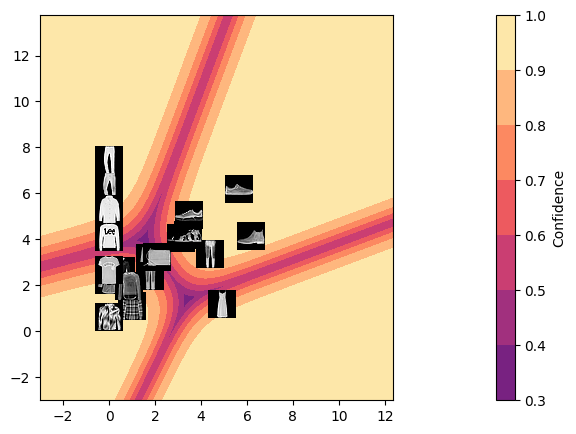

In [212]:
inputs, targets = next(iter(testloader_fashion))
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=20)

## 4a

In [213]:
model = Embed()
# get random input image
sample_image, sample_label = next(iter(trainloader))
input_tensor = sample_image
input_tensor.shape

torch.Size([128, 1, 28, 28])

In [214]:
# print shape at each point of iteration
out = F.relu(model.conv1(input_tensor))
print("out1: ", out.shape)
out = F.max_pool2d(out, 2)
print("out2: ", out.shape)
out = F.relu(model.conv2(out))
print("out3: ", out.shape)
out = F.max_pool2d(out, 2)
print("out4: ", out.shape)
out = out.view(out.size(0), -1)
print("out5: ", out.shape)
out = F.relu(model.fc1(out))
print("out6: ", out.shape)
out = F.relu(model.fc2(out))
print("out7: ", out.shape)

out1:  torch.Size([128, 6, 24, 24])
out2:  torch.Size([128, 6, 12, 12])
out3:  torch.Size([128, 16, 8, 8])
out4:  torch.Size([128, 16, 4, 4])
out5:  torch.Size([128, 256])
out6:  torch.Size([128, 120])
out7:  torch.Size([128, 84])


## 4b

==> Preparing data..


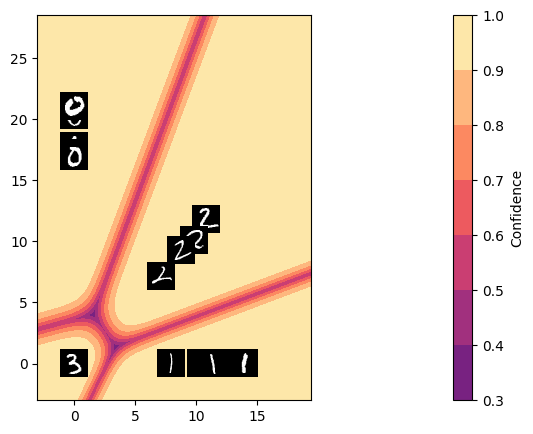

In [215]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

inputs, targets = next(iter(testloader))
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=20)

In [216]:
for name, param in net.named_parameters():
    if (name == "classifier.weight" or name == "classifier.bias"):
        print(name)
        print(param)

classifier.weight
Parameter containing:
tensor([[-1.2554,  1.2776],
        [ 1.2635, -1.3531],
        [ 0.5267,  0.6106],
        [-0.8194, -0.3296]], requires_grad=True)
classifier.bias
Parameter containing:
tensor([-1.4971, -1.3877, -1.5788,  4.3174], requires_grad=True)
